In [11]:
from context_analysis.load import load_behaviour, load_traces, load_mice
from context_analysis.reshape import split_by_group, split_by_mouse
from context_analysis.resample import temporally_align_onep_behaviour
from context_analysis.onep.reshape import pivot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
def preprocess(traces, behaviour, time_interval, behaviour_metric="freeze_status", round_metric: bool = True, time_col="time"):
    traces = pivot(traces)
    traces, behaviour = temporally_align_onep_behaviour(
    traces.reset_index(), behaviour[["time", behaviour_metric]], new_interval=time_interval
    )
    if round_metric:
        behaviour[behaviour_metric] = behaviour[behaviour_metric].round()
    X = traces.set_index("time")
    y = behaviour.set_index("time")["freeze_status"]
    return X, y



def fit_model(X, y, pipe):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    score = metrics.f1_score(y_test, y_hat)
    return score, pipe

In [3]:
def fit_model_per_mouse(pipe, traces_dict, behaviour_dict, time_interval="500ms"):
    all_scores = []
    all_groups = []
    all_mice = []
    all_models = []
    for group in behaviour_dict.keys():
        mice = list(behaviour_dict[group].keys())
        for mouse in mice:
            t = traces_dict[group][mouse]
            b = behaviour_dict[group][mouse]
            X, y = preprocess(t, b, time_interval=time_interval)
            try:
                score, model = fit_model(X, y, clone(pipe))
            except ValueError:
                score, model = np.nan, np.nan
            all_scores.append(score)
            all_models.append(model)
            all_mice.append(mouse)
            all_groups.append(group)
    return pd.DataFrame({"mouse": all_mice, "group": all_groups, "score": all_scores, "model": all_models})
            

In [4]:
session_name = "day4-test1"
traces_test1 = load_traces(experiment="pfc", session_names=[session_name])
behaviour_test1 = load_behaviour(experiment="pfc", session_names=[session_name])
behaviour_test1["time"] = behaviour_test1["frame"].mul(1/30)
traces_by_mouse_test1 = split_by_mouse(experiment="pfc", df=traces_test1)
behaviour_by_mouse_test1 = split_by_mouse(experiment="pfc", df=behaviour_test1)

In [5]:
session_name = "day5-test2"
traces_test2 = load_traces(experiment="pfc", session_names=[session_name])
behaviour_test2 = load_behaviour(experiment="pfc", session_names=[session_name])
behaviour_test2["time"] = behaviour_test2["frame"].mul(1/30)
traces_by_mouse_test2 = split_by_mouse(experiment="pfc", df=traces_test2)
behaviour_by_mouse_test2 = split_by_mouse(experiment="pfc", df=behaviour_test2)

In [6]:
clf = LogisticRegression(C=1, penalty="elasticnet", solver='saga', l1_ratio=0.1)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("clf", clf)
])

In [33]:
time_interval = "1s"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_test1 = fit_model_per_mouse(clone(pipe), traces_by_mouse_test1, behaviour_by_mouse_test1, time_interval=time_interval)
    res_test2 = fit_model_per_mouse(clone(pipe), traces_by_mouse_test2, behaviour_by_mouse_test2, time_interval=time_interval)

df = pd.concat([res_test1.assign(session="test1"), res_test2.assign(session="test2")])

In [25]:
# df = pd.DataFrame(scores).melt(var_name="group", value_name="f1_score")

<AxesSubplot:xlabel='group', ylabel='score'>

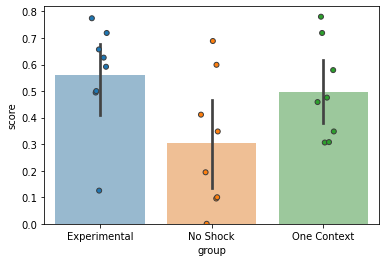

In [34]:
ax = sns.stripplot(y="score", x="group", data=df,
                   linewidth=1)

sns.barplot(x="group", y="score", data=df, alpha=0.5)


In [35]:
import statsmodels.formula.api as smf

model = smf.ols("score ~ group", data=df[["score", "group", "session"]].dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     3.137
Date:                Fri, 03 Sep 2021   Prob (F-statistic):             0.0643
Time:                        11:02:36   Log-Likelihood:                 4.6565
No. Observations:                  24   AIC:                            -3.313
Df Residuals:                      21   BIC:                            0.2211
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5608      0.075      7.445      0.000       0.404       0.717
group[T.No Shock]       -0.2564      0.107     -2.407      0.025      -0.478      -0.035
group[T.One Context]    -0.0642      0.107     -0.602      0.553      -0.286       0.157
==============================================================================
Omnibus:                        0.115   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.328
Skew:                          -0.079   Prob(JB):                        0.849
Kurtosis:                       2.449   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""